# AI Workshop - Lab 2-1: Computer Vision

In this lab, we will use pre-trained models to classify machine part defects. Like yesterday, we will be working with Keras and TensorFlow, but this time we will use the `tf.keras.applications` module to load pre-trained models.

### Data Overview

The dataset provided for this lab contains images of an automotive part, the **Fender Apron**, captured under varying conditions such as different angles and scales. The dataset has already been labeled as either **defective** or **healthy**, making it ideal for supervised learning tasks.

- **Total Images**: 250
  - **Healthy Parts**: 139 images
  - **Defective Parts**: 111 images
- **Train/Test Split**:
  - **Training Set**: 90% of the data
  - **Test Set**: 10% of the data (25 randomly selected images)

### Key Steps in Lab
1. **Exploration**: We'll start by visualizing the dataset, inspecting some sample images to understand variations and potential challenges.
2. **Preprocessing**: Learn to preprocess images by resizing, normalizing pixel values, and augmenting the dataset to simulate real-world scenarios.
3. **Model Selection**:
   - We'll use the MobileNetV2 architecture, a lightweight and efficient model available in `tf.keras.applications`.
   - The pre-trained model will be fine-tuned to classify images into **defective** and **healthy** categories.
4. **Evaluation**:
   - Evaluate model performance using metrics such as **f1-score**, **precision**, and **recall**.
   - Analyze confusion matrices and visualize predictions for better interpretability.

### Goals
By the end of this lab, you will:
- Understand the concept of transfer learning and how to adapt a pre-trained model to solve specific problems.
- Gain hands-on experience with training and deploying a defect detection system.

Now, let's dive into the **dataset preparation** and explore how these images can be preprocessed for model training!

### Loading the Dataset

We will start by loading the dataset and visualizing a few sample images to understand the data distribution and characteristics. The dataset is already organized for you into training and testing sets, with separate folders for **defective** and **healthy** parts. Keras makes it easy for us to load images like this using the `image_dataset_from_directory` function.

The following command will download the dataset to your workspace using `wget`, a command-line utility for downloading files from the web. Run the cell below to download the dataset.

In [1]:
!wget https://github.com/alexwolson/mdlw_materials/raw/refs/heads/main/data/parts_dataset.tar.gz

--2024-12-02 12:02:03--  https://github.com/alexwolson/mdlw_materials/raw/refs/heads/main/data/parts_dataset.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexwolson/mdlw_materials/refs/heads/main/data/parts_dataset.tar.gz [following]
--2024-12-02 12:02:03--  https://raw.githubusercontent.com/alexwolson/mdlw_materials/refs/heads/main/data/parts_dataset.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15614901 (15M) [application/octet-stream]
Saving to: ‘parts_dataset.tar.gz.11’

parts_dataset.tar.g 100%[===================>]  14.89M  --.-KB/s    in 0.1s    

2024-12-02 12:02:04 (1

Next, we will extract the dataset using the `tar` command. Run the cell below to extract the dataset.

In [2]:
!tar -xf parts_dataset.tar.gz

In this section, we will load our image dataset into TensorFlow for training and evaluation. TensorFlow provides an easy-to-use utility, `image_dataset_from_directory`, to load and preprocess image data directly from a directory structure.

#### Steps:
1. **Organizing the Dataset**:
   - The dataset is stored in a directory called `parts_dataset`, with subfolders for `train` and `test`.
   - Each subfolder contains images organized by class (e.g., "defective" and "healthy").

2. **Loading the Data**:
   - We use `image_dataset_from_directory` to load images from the `train` and `test` directories.
   - Images are resized to **224x224 pixels** (a common size for models like MobileNetV2).
   - The dataset is divided into **batches of 32 images** for efficient training.

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from keras.layers import Rescaling, RandomCrop, RandomFlip, RandomRotation, RandomZoom, RandomContrast, \
    GlobalAveragePooling2D, Dense, Input
from keras.models import Model, Sequential
from keras.preprocessing import image, image_dataset_from_directory

2024-12-02 12:02:04.777111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 12:02:04.795878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733158924.818125   13249 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733158924.822483   13249 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 12:02:04.835737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
# Define the dataset directory
dataset_dir = Path('parts_dataset')

# Load the dataset
train_dataset = image_dataset_from_directory(
    dataset_dir / 'train',
    image_size=(224, 224),
    batch_size=32,
)

test_dataset = image_dataset_from_directory(
    dataset_dir / 'test',
    image_size=(224, 224),
    batch_size=32,
)

Found 199 files belonging to 2 classes.
Found 51 files belonging to 2 classes.


W0000 00:00:1733158926.585806   13249 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


To better understand our dataset, it’s helpful to visualize some sample images along with their corresponding labels. This can give us insight into the data quality, variations, and any potential preprocessing needs.

#### Steps:
1. **Take a Batch**:
   - Use the `.take(1)` method to extract the first batch of images and labels from the `train_dataset`.
2. **Display Images**:
   - Use `matplotlib.pyplot` to create a grid of 3x3 images (9 total).
   - Convert the image tensors to NumPy arrays and ensure the pixel values are properly scaled for display.
3. **Label the Images**:
   - Assign a title of "defective" or "healthy" based on the label value (e.g., `0` for defective and `1` for healthy).

2024-12-02 12:02:06.836197: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


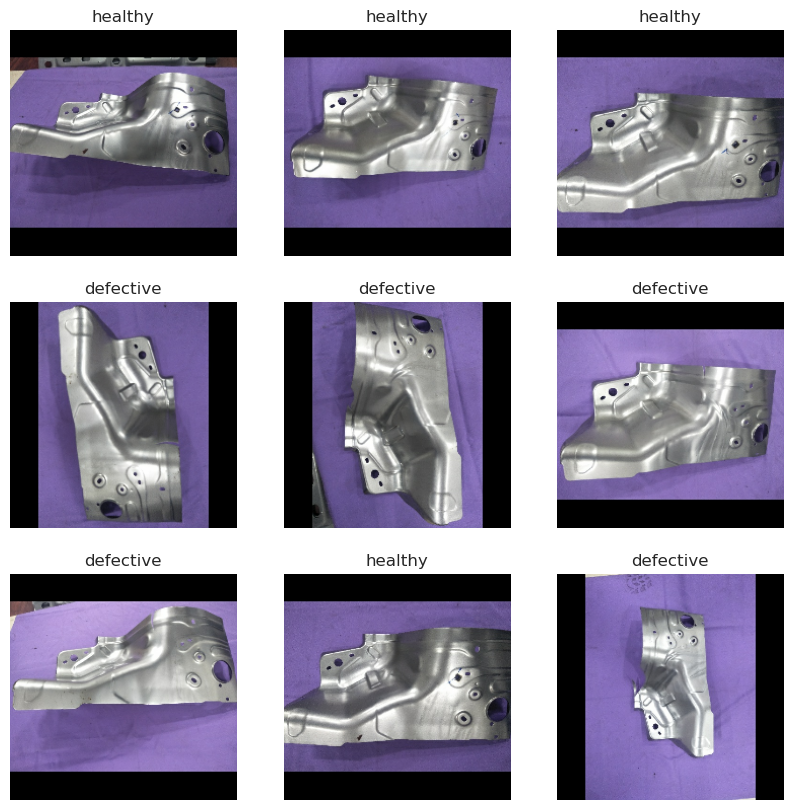

In [5]:
# Visualize the first 9 images from the training set
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):                          # Take the first batch from the training dataset
    for i in range(9):                                                # Loop through the first 9 images in the batch
        ax = plt.subplot(3, 3, i + 1)                                 # Create a 3x3 grid of subplots
        plt.imshow(images[i].numpy().astype("uint8"))                 # Display the image
        plt.title("defective" if labels[i] == 0 else "healthy")       # Add a title based on the label
        plt.axis("off")                                               # Remove axis lines for cleaner visualization

### Preprocessing the Images

When working with image data, preprocessing is a crucial step to prepare the dataset for training a machine learning model. Preprocessing ensures that the data is in the right format, size, and range for optimal performance. Let's review what has already been done for you and what still needs to be completed.

#### Preprocessing Already Done:
1. **Resizing**:
   - The original images (4160 × 3120 pixels) were too large for most models.
   - They have been resized to 224 × 224 pixels for training, with padding (black bars) added where necessary to maintain a 1:1 aspect ratio.
2. **Train-Test Split**:
   - The dataset has been split into training (90%) and testing (10%) sets, so you can focus on model training and evaluation separately.

#### Preprocessing to Complete:
Now it's your turn to finish preprocessing. Here's what we'll do next:
1. **Normalization**:
   - Rescale pixel values from their original range ([0, 255]) to the range [0, 1]. This helps models train more effectively by ensuring consistent input scales.
2. **Data Augmentation**:
   - Apply random transformations (e.g., flips, rotations, zooms) to the training images to simulate variations seen in real-world scenarios. This enhances the model’s ability to generalize.
3. **Dataset Configuration**:
   - Optimize dataset performance by applying prefetching, caching, and shuffling techniques.

#### Viewing the Data:
For models, images are represented as matrices of pixel values. Run the code below to inspect the shape of the first image in the training set and view its pixel values (specifically a slice through the middle of the image).

In [6]:
for images, labels in train_dataset.take(1):
    print("Image Shape:", images[0].shape)            # Shape of the first image in the training set
    print("Pixel Values (Row 100):", images[0][100])  # Pixel values in the 100th row
    break

Image Shape: (224, 224, 3)
Pixel Values (Row 100): tf.Tensor(
[[128.7347   108.734695 177.7347  ]
 [129.02042  108.02041  175.02042 ]
 [132.81631  111.816315 178.81631 ]
 [129.57147  108.57147  173.57147 ]
 [133.6939   111.83677  177.12247 ]
 [136.26526  115.265274 182.26526 ]
 [133.38771  112.38771  179.51016 ]
 [128.93884  113.081696 169.40826 ]
 [107.244965  96.775566 128.24503 ]
 [ 99.203995  89.346855 101.24483 ]
 [105.42853   94.42853  110.99992 ]
 [102.75514   90.26535  117.32651 ]
 [104.28573   94.81634  118.571434]
 [ 99.89802   91.89802  112.89802 ]
 [ 88.63272   83.63272  106.20415 ]
 [ 52.306435  47.510513  76.69418 ]
 [ 43.387794  36.408207  68.816345]
 [ 86.28528   72.71388  122.57094 ]
 [123.77555  103.632706 172.38776 ]
 [132.5714   110.85711  181.99997 ]
 [130.08162  108.65307  174.79591 ]
 [128.85718  106.28574  173.00003 ]
 [126.02037  104.44894  170.30609 ]
 [116.95923   96.93881  158.51027 ]
 [108.85713   88.85713  147.85713 ]
 [108.77552   88.77552  147.77553 ]
 [

As you can see from the output above, the pixel values of the images are currently in the range [0, 255]. Each pixel has three values (red, green, and blue), corresponding to the **RGB format** of the image. This format allows the model to process color images, with each color channel represented as a separate value.

### Normalizing Pixel Values
To prepare the images for training, we need to normalize the pixel values to the range [0, 1]. Normalization ensures that:
1. The model trains more effectively by reducing the variability in input values.
2. The input values are on a consistent scale, which helps gradient-based optimization algorithms converge faster.

We will use Keras's `Rescaling` layer to handle the normalization process. The `Rescaling` layer applies a simple transformation:

$$
\text{Normalized Value} = \text{Original Value} \times \frac{1}{255}
$$

#### Steps:
1. Create a normalization layer using `Rescaling(1./255)`, which divides all pixel values by 255.
2. Apply the normalization layer to the training dataset using the `map()` function, which processes each image in the dataset.

Run the following code to normalize the dataset:

In [7]:
# Create a normalization layer
normalization_layer = Rescaling(1./255)

# Apply normalization to the training dataset
normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

In [8]:
for images, labels in normalized_train_dataset.take(1):
    print("Image Shape:", images[0].shape)                       # Shape of the normalized image
    print("Normalized Pixel Values (Row 100):", images[0][100])  # Pixel values in the 100th row
    break

Image Shape: (224, 224, 3)
Normalized Pixel Values (Row 100): tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+

### Data Augmentation: Enhancing Generalization

With the pixel values normalized, the next step in preprocessing is **data augmentation**, which helps improve the model's ability to generalize to unseen data. By applying random transformations to the training images, we can:
- Simulate variations found in real-world scenarios.
- Reduce overfitting by artificially increasing the diversity of the training dataset.

Data augmentation helps the model learn **invariance** to changes that don’t matter for the task at hand. For instance:
- **Flipping** or **rotating** an image should not affect whether the model identifies a defect.
- Variations in **brightness**, **contrast**, or **zoom** should not change the model’s prediction.

By applying these random transformations, we teach the model to focus on meaningful patterns in the data, rather than being misled by irrelevant differences. This improves robustness and generalization, especially when the training dataset is small.

#### Augmentation in Keras
Keras provides convenient **image augmentation layers** that can be added directly to the model architecture or applied as a preprocessing step. These layers make it simple to experiment with different strategies.

The augmentation layers we’ll use include:
- **RandomCrop**: Crops the image to a specified size.
- **RandomFlip**: Flips the image horizontally or vertically.
- **RandomRotation**: Rotates the image by a random angle within a specified range.
- **RandomZoom**: Zooms in or out of the image.
- **RandomContrast**: Adjusts the contrast of the image randomly.

#### Visualizing Augmented Images
To better understand each augmentation, we will visualize the effects of individual transformations. For each augmentation layer, we’ll show:
1. The **original image**.
2. The **augmented image** after applying the transformation.


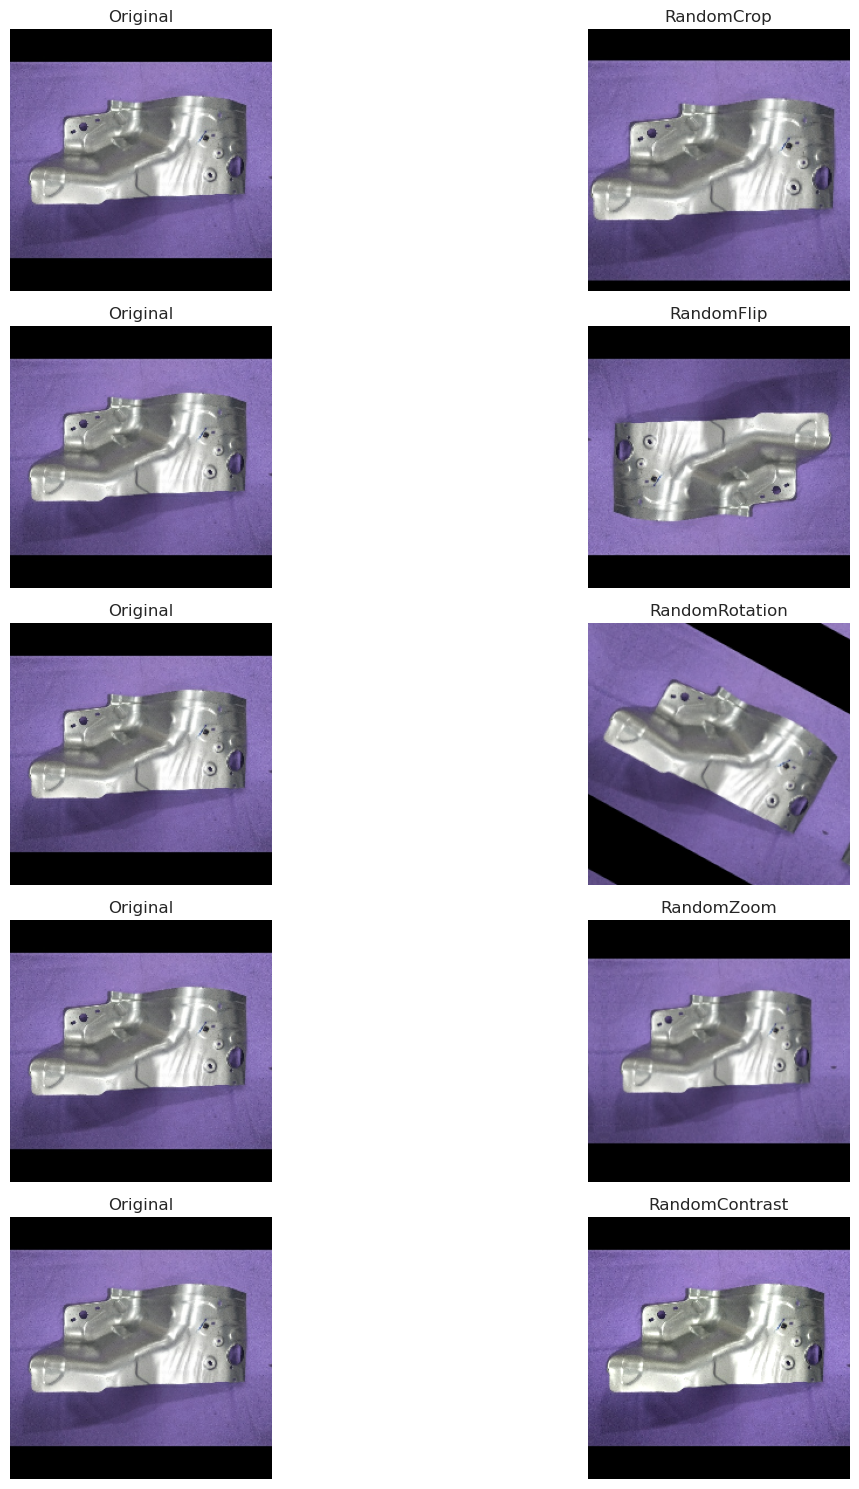

In [9]:
# Define individual augmentation layers
augmentation_layers = {
    "RandomCrop": RandomCrop(200, 200),  # Crop image to 200x200
    "RandomFlip": RandomFlip("horizontal_and_vertical"),  # Flip horizontally and vertically
    "RandomRotation": RandomRotation(0.2),  # Rotate by up to 20%
    "RandomZoom": RandomZoom(0.2, 0.2),  # Zoom in or out
    "RandomContrast": RandomContrast(0.2),  # Adjust contrast
}

# Select one image to demonstrate augmentations
for images, labels in normalized_train_dataset.take(1):
    original_image = images[0].numpy().astype("float32")
    break

# Plot original image and augmented versions
plt.figure(figsize=(15, 15))
for i, (name, layer) in enumerate(augmentation_layers.items()):
    augmented_image = layer(tf.expand_dims(original_image, 0))  # Apply augmentation
    augmented_image = augmented_image[0].numpy()  # Remove batch dimension
    augmented_image = tf.clip_by_value(augmented_image, 0.0, 1.0).numpy()  # Clip values to [0, 1]

    # Display original image
    ax = plt.subplot(len(augmentation_layers), 2, i * 2 + 1)
    plt.imshow(original_image)
    plt.title("Original")
    plt.axis("off")

    # Display augmented image
    ax = plt.subplot(len(augmentation_layers), 2, i * 2 + 2)
    plt.imshow(augmented_image)
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Model Selection: MobileNetV2 Pre-trained on ImageNet

When training a model for a specific task, it’s often easier to start with an **existing model** that has already been trained on a large, general-purpose dataset. These models are called **pre-trained models**, and they save a lot of time and computational resources because they have already learned to recognize patterns and features from a wide range of images.

In this lab, we’re using **MobileNetV2**, a pre-trained model that was trained on a dataset called **ImageNet**. ImageNet is a collection of over 1 million images grouped into 1,000 categories, such as dogs, cats, elephants, and more. The MobileNetV2 model has learned to identify these categories very well.

Before we adapt MobileNetV2 for our defect detection task, let’s see how it works on its original training data by:
1. Loading the pre-trained MobileNetV2 model.
2. Testing it on a few sample images from ImageNet-like categories.
3. Viewing its predictions to understand what it has already learned.

---

### What is MobileNetV2 Doing?

MobileNetV2 is like a complex decision-making process:
1. **Lower Layers**: Detect simple features, like edges or textures.
2. **Middle Layers**: Combine these simple features into more complex ones, like shapes or objects.
3. **Top Layers**: Decide on the most likely category (e.g., “dog,” “cat”) using what it has learned during training.

Right now, the MobileNetV2 model is trained to identify objects in ImageNet categories, but we’ll see how it performs by testing it on a few example images.


---

### Step 1: Load the Pre-trained MobileNetV2 Model

The `MobileNetV2` model is available in `tf.keras.applications`, and we can load it with just one line of code:

In [10]:
# Load MobileNetV2 with the original classification head
imagenet_model = MobileNetV2(weights='imagenet', include_top=True)

### Step 2: Load and Preprocess Sample Images

To use MobileNetV2, the input images must be prepared in a specific way:

1. Resize the images to 224 × 224 pixels (the size MobileNetV2 expects).
2. Normalize the pixel values to match how the model was trained.

We’ll use some sample images of objects like a dog, a cat, and an elephant to test the model:

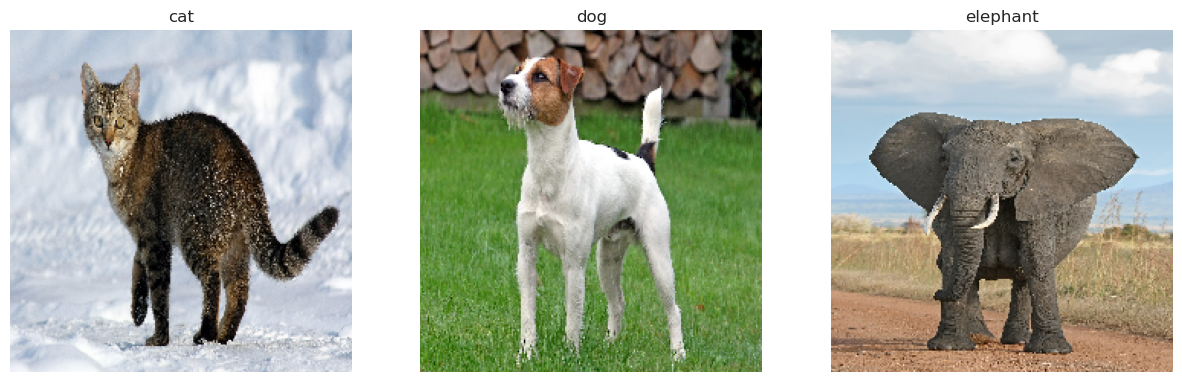

In [11]:
urls = {
    "cat":"https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Felis_catus-cat_on_snow.jpg/1920px-Felis_catus-cat_on_snow.jpg",
    "dog":"https://upload.wikimedia.org/wikipedia/commons/9/99/Brooks_Chase_Ranger_of_Jolly_Dogs_Jack_Russell.jpg",
    "elephant":"https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/African_Bush_Elephant.jpg/1024px-African_Bush_Elephant.jpg"
}

# Load and preprocess the sample images
sample_images = {}
for name, url in urls.items():
    img_path = tf.keras.utils.get_file(f"{name}.jpg", url)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    sample_images[name] = img_array

# Display the sample images
plt.figure(figsize=(15, 5))
for i, (name, img_array) in enumerate(sample_images.items()):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow((img_array+1)/2) # Rescale pixel values to [0, 1] - in MobileNetV2 the range is [-1, 1]
    plt.title(name)
    plt.axis("off")

### Step 3: Use MobileNetV2 to Make Predictions

Now let’s use the model to predict what it sees in the images. The predictions will be probabilities for each of the 1,000 categories, and we’ll decode these to show the most likely categories:

In [12]:
# Make predictions on the sample images
predictions = {}
for name, img_array in sample_images.items():
    predictions[name] = decode_predictions(imagenet_model.predict(np.expand_dims(img_array, axis=0)), top=3)

# Display the predictions
for name, preds in predictions.items():
    print(f"Predictions for {name}:")
    for pred in preds[0]:
        print(f"  {pred[1]}: {pred[2]*100:.0f}%")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predictions for cat:
  lynx: 34%
  Egyptian_cat: 6%
  tabby: 4%

Predictions for dog:
  wire-haired_fox_terrier: 15%
  basenji: 13%
  toy_terrier: 8%

Predictions for elephant:
  African_elephant: 58%
  Indian_elephant: 15%
  tusker: 11%



### Why Is This Helpful?

You might be wondering: if MobileNetV2 is trained to recognize objects like dogs, cats, and elephants, how does this help us distinguish between defective and healthy auto parts? The key lies in understanding **feature extraction** and how pre-trained models like MobileNetV2 learn to recognize patterns.

#### What MobileNetV2 Has Learned
1. **Low-Level Features**: The early layers of MobileNetV2 detect basic patterns like edges, corners, and textures. These features are universal—they’re useful for understanding any image, whether it’s a dog or an auto part.
2. **High-Level Features**: The deeper layers combine these patterns into more complex shapes, like wheels or fur. These features are specific to the ImageNet dataset and won’t directly help with our defect detection task.

By reusing the **low-level feature extraction** layers and replacing the high-level layers with new ones tailored to our dataset, we save time and computational effort. Instead of training from scratch, we only need to teach the model how to use these general features to distinguish defective parts from healthy ones.

---

### Visualizing the Receptive Fields of Early Layers

To see why these low-level features are useful, let’s visualize what the **early layers** of MobileNetV2 focus on when processing an image. These layers form the building blocks of the model’s understanding of visual data.

---

#### Step 1: Load the Base Model
We’ll load the MobileNetV2 model but stop at an early layer to analyze the features it extracts:

In [13]:
# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False)
layer_name = 'block_1_expand'  # Choose an early layer
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

/tmp/ipykernel_13249/2953287777.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


### Step 2: Visualize Receptive Fields

Let’s pass an image through the feature extractor and visualize the activation maps. These maps show which parts of the image the model focuses on at different positions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


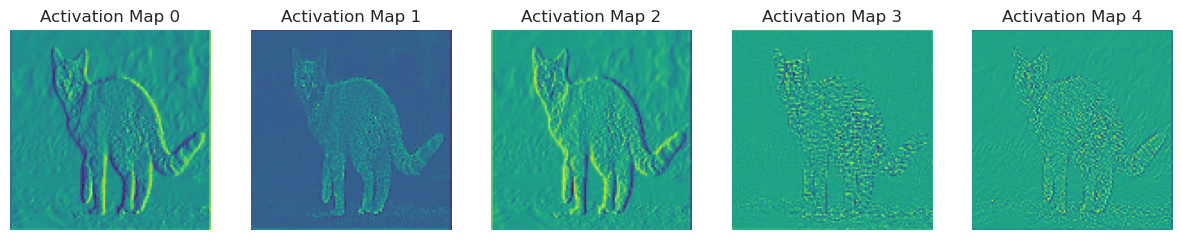

In [14]:
img_array = sample_images["cat"]  # Choose an image to visualize

# Get the activation maps
activations = feature_extractor.predict(np.expand_dims(img_array, axis=0))

# Visualize the activation maps
plt.figure(figsize=(15, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis("off")
    plt.title(f"Activation Map {i}")

### What Do We See?

The activation maps highlight edges, corners, and textures in the image. These low-level patterns are essential for understanding any visual data, including auto parts. Even though the model was trained on ImageNet, these universal features apply to other tasks, like identifying defects in auto parts.

### Connecting This to Auto Parts

When distinguishing defective auto parts, the model doesn’t need to know what the part is—it just needs to identify patterns that differentiate a healthy part from a defective one. The low-level features learned by MobileNetV2:

1. Help detect scratches, cracks, or texture anomalies.
2. Provide a foundation for recognizing visual inconsistencies.

By keeping these early layers and fine-tuning the top layers, we can adapt MobileNetV2 to focus on defect detection without starting from scratch.

This reuse of pre-trained features is what makes transfer learning so powerful, saving time and making the model both efficient and effective.

# Model Selection

With this intro in mind, we are now ready to set up the model for defect detection. We will use the MobileNetV2 architecture as the base model and fine-tune it for our specific task. The model will be trained to classify images into two categories: **defective** and **healthy** parts.

## Step 1: Load the Pre-trained Model

We begin by loading MobileNetV2 with pre-trained weights. Since our task is different from the original ImageNet classification, we’ll:
1. Remove the top layers of MobileNetV2 (responsible for ImageNet-specific classifications).
2. Keep the base layers, which extract general visual features.

In [15]:
# Load MobileNetV2 without the top classification layers
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude ImageNet-specific top layers
    weights='imagenet'  # Use pre-trained weights
)

# Freeze layers
base_model.trainable = False

# We are also going to pre-process our images to be between [-1, 1] which is what MobileNetV2 expects
def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

Why freeze the base layers? We want to retain the general features learned from ImageNet without altering them. Instead, we’ll train new layers on top to focus on our specific task.

### Step 2: Add Task-Specific Layers

To adapt MobileNetV2 to defect detection, we’ll add new layers:

- **Global Average Pooling**: Reduces the feature maps from the base model into a single vector, summarizing important information.
- **Fully Connected Layer**: Adds additional learnable parameters for our task.
- **Output Layer**: Produces a single probability (0 = healthy, 1 = defective) using a **sigmoid** activation.

In [16]:
# Build the complete model
model = Sequential([
    Input(shape=(224, 224, 3)),       # Input shape matches the pre-trained model
    base_model,                       # Use the frozen MobileNetV2 base
    GlobalAveragePooling2D(),         # Reduce spatial dimensions to a single vector
    Dense(128, activation='relu'),    # Learnable dense layer
    Dense(64, activation='relu'),     # Additional dense layer
    Dense(1, activation='sigmoid')    # Output layer for binary classification
])

# Display the model structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,273 (9.27 MB)

 Trainable params: 172,289 (673.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Notice that unlike yesterday, we now have a distinction between **trainable** and **non-trainable** parameters. This means that we have instructed Keras not to update the weights of the MobileNetV2 base model during training. Instead, only the new layers we added will be trained to classify defective and healthy parts.

### Step 4: Compile the Model

Next, we compile the model to define:

- Loss Function: binary_crossentropy for binary classification. Binary Cross-Entropy calculates the error based on *how confident* the model is in its predictions. In principle, the model should only ever be *very confident* about a good prediction, or failing that, *not very confident* at all. It's calculated as follows:

$$
\text{Binary Cross-Entropy} = -\frac{1}{N} \sum_{i=1}^{N} y_i \log(p_i) + (1 - y_i) \log(1 - p_i)
$$

- Optimizer: For now we'll stick with Stochastic Gradient Descent (SGD), but you can experiment with other optimizers like Adam or RMSprop at the end of the lab.
- Metrics: Accuracy, to monitor performance.

In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Step 5: Train the Model

Finally, we train the model on the dataset for 15 epochs and validate its performance. We will also optimize data loading using Keras' `prefetch` method, which loads data in the background while the model is training.

In [18]:
# Optimize data loading for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Train the model
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 930ms/step - accuracy: 0.5293 - loss: 0.8035 - val_accuracy: 0.5490 - val_loss: 0.6789
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 836ms/step - accuracy: 0.6602 - loss: 0.6123 - val_accuracy: 0.6471 - val_loss: 0.6106
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 719ms/step - accuracy: 0.7831 - loss: 0.5397 - val_accuracy: 0.7255 - val_loss: 0.5713
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 715ms/step - accuracy: 0.8162 - loss: 0.4563 - val_accuracy: 0.7255 - val_loss: 0.5633
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 710ms/step - accuracy: 0.7965 - loss: 0.4238 - val_accuracy: 0.7255 - val_loss: 0.5004
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 704ms/step - accuracy: 0.8688 - loss: 0.3338 - val_accuracy: 0.7647 - val_loss: 0.4725
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 701ms/step - accuracy: 0.8902 - loss: 0.2759 - val_accuracy: 0.8039 - val_loss: 0.5049
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 703ms/step - accuracy: 0.9401 - loss: 0.2349 - val_accuracy: 0.7647 - val_loss

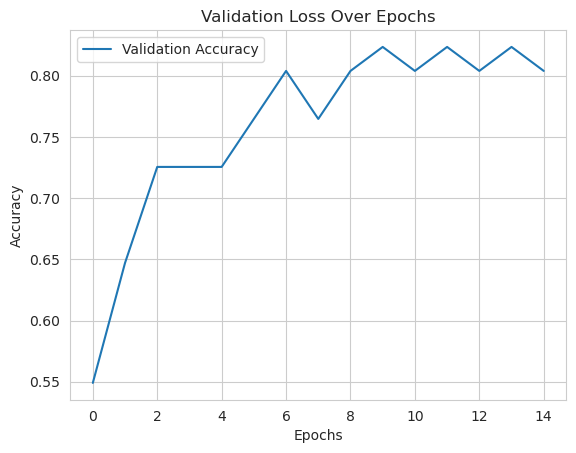

In [19]:
import matplotlib.pyplot as plt

# Plot the validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.show()

### Evaluating Model Performance: Detailed Breakdown

Now that the model is trained, let’s take a closer look at its performance on the **testing set**. While accuracy gives us a general idea of how well the model is doing, it’s often helpful to use other metrics to better understand its behavior. We’ll compute:
1. **Confusion Matrix**: A summary of true positives, true negatives, false positives, and false negatives.
2. **Precision and Recall**: To understand how well the model identifies defective parts.
3. **F1-Score**: A harmonic mean of precision and recall, giving a single metric that balances the two.

Let’s also visualize the confusion matrix to make the results more interpretable.

2024-12-02 12:03:35.318943: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 915ms/step


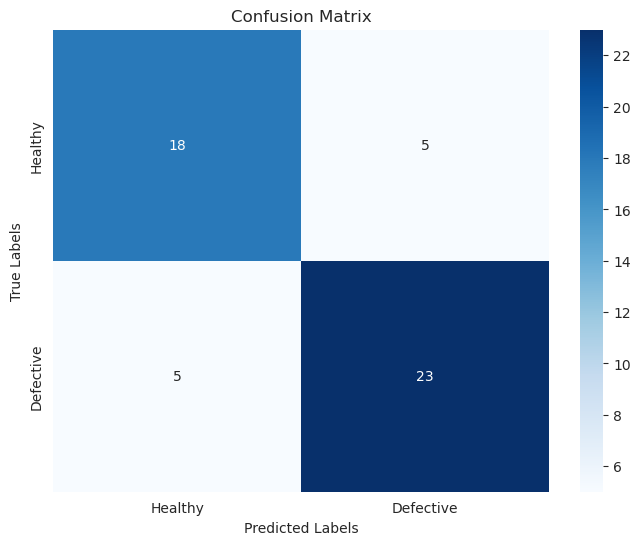

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.78      0.78      0.78        23
   Defective       0.82      0.82      0.82        28

    accuracy                           0.80        51
   macro avg       0.80      0.80      0.80        51
weighted avg       0.80      0.80      0.80        51



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Predict on the testing set
test_images, test_labels = [], []
for images, labels in test_dataset:
    test_images.append(images)
    test_labels.append(labels)
test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Step 2: Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Step 3: Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Defective'], yticklabels=['Healthy', 'Defective'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Generate the classification report
report = classification_report(test_labels, predicted_labels, target_names=['Healthy', 'Defective'])
print("Classification Report:")
print(report)

### Analyzing Misclassified and Low-Confidence Samples

To better understand the model’s performance, let’s inspect:
1. **Misclassified Samples**: Images that the model got wrong. This helps us identify patterns in its mistakes.
2. **Low-Confidence Correct Predictions**: Images that were classified correctly but with a low confidence score. These can reveal edge cases where the model is uncertain.

We will visualize these samples alongside their predicted labels and confidence scores to understand where the model struggles and why.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
Total misclassified samples: 10


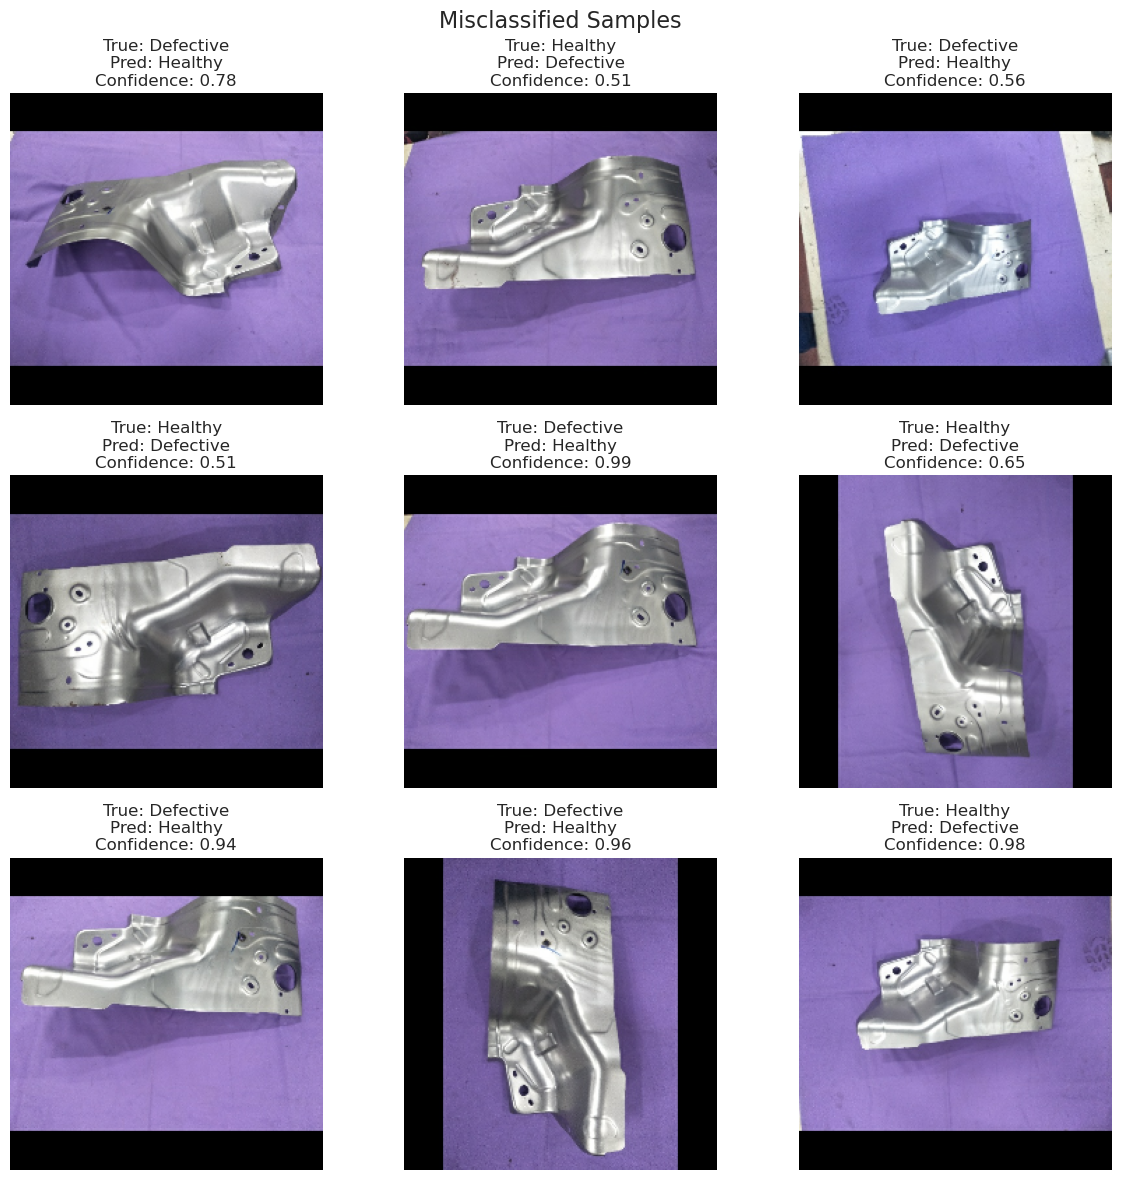

Total low-confidence correct samples: 3


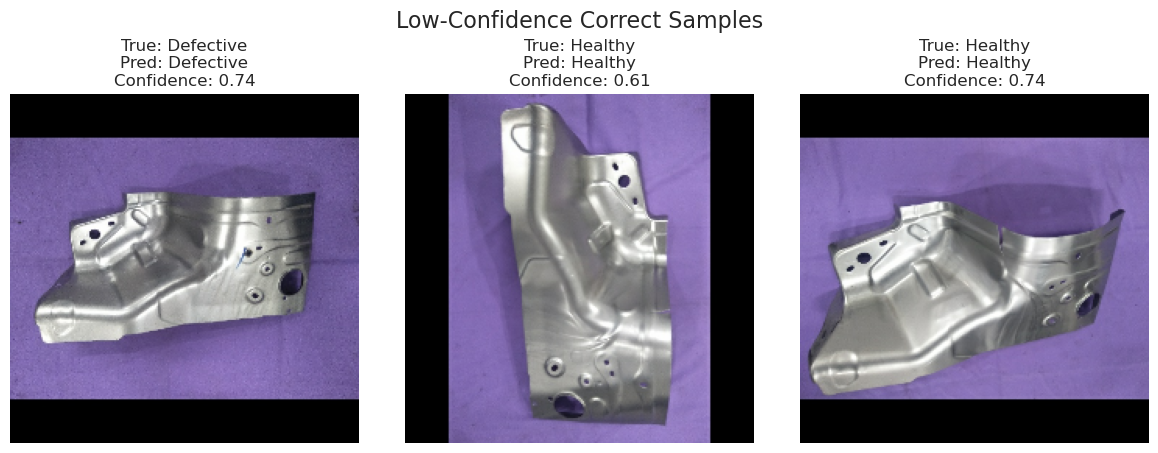

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Predict on the testing set
predictions = model.predict(test_images).flatten()
predicted_labels = (predictions > 0.5).astype(int)
confidence_scores = np.where(predictions < 0.5, 1 - predictions, predictions)

# Step 2: Identify misclassified samples
misclassified_indices = np.where(predicted_labels != test_labels)[0]

# Step 3: Identify low-confidence correct samples
low_confidence_correct_indices = np.where(
    (predicted_labels == test_labels) & (confidence_scores < 0.75)
)[0]

# Step 4: Define a function to visualize samples
def visualize_samples(indices, title, num_samples=9):
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(indices[:num_samples]):
        plt.subplot(3, 3, i + 1)
        plt.imshow((test_images[idx] + 1)/2)
        plt.axis("off")
        plt.title(
            f"True: {'Defective' if test_labels[idx] else 'Healthy'}\n"
            f"Pred: {'Defective' if predicted_labels[idx] else 'Healthy'}\n"
            f"Confidence: {confidence_scores[idx]:.2f}"
        )
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Step 5: Visualize misclassified samples
print(f"Total misclassified samples: {len(misclassified_indices)}")
visualize_samples(misclassified_indices, "Misclassified Samples")

# Step 6: Visualize low-confidence correct samples
print(f"Total low-confidence correct samples: {len(low_confidence_correct_indices)}")
visualize_samples(low_confidence_correct_indices, "Low-Confidence Correct Samples")

### Comparing Activation Maps: Pre-trained vs. Fine-tuned Model

Now that our model has been fine-tuned, let’s revisit the **activation maps** from the `block_1_expand` layer. This time, we’ll compare how the pre-trained MobileNetV2 and the fine-tuned model process:
1. A **cat image** (used earlier to observe pre-trained activations).
2. An image from our **defect detection dataset**.

This comparison helps us understand how the model’s feature extraction has adapted to the new task.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


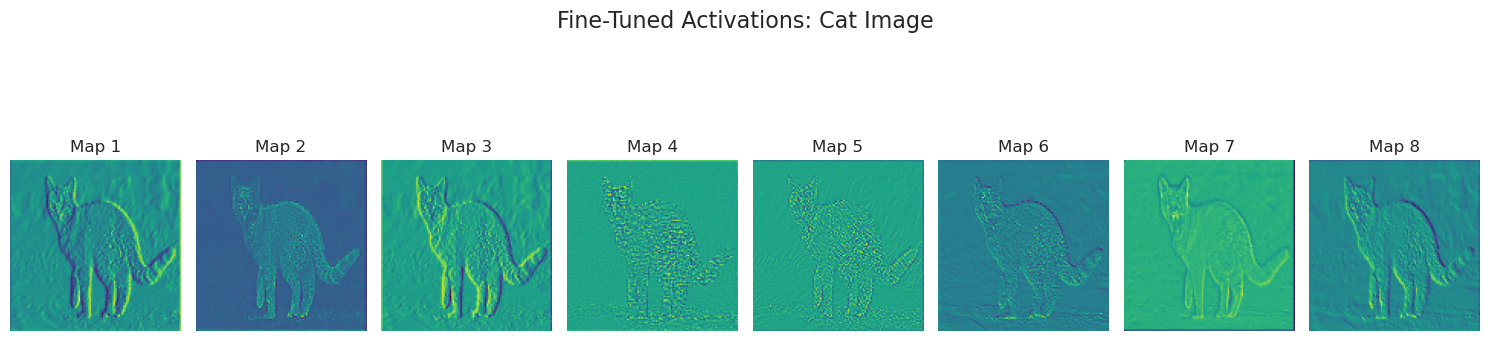

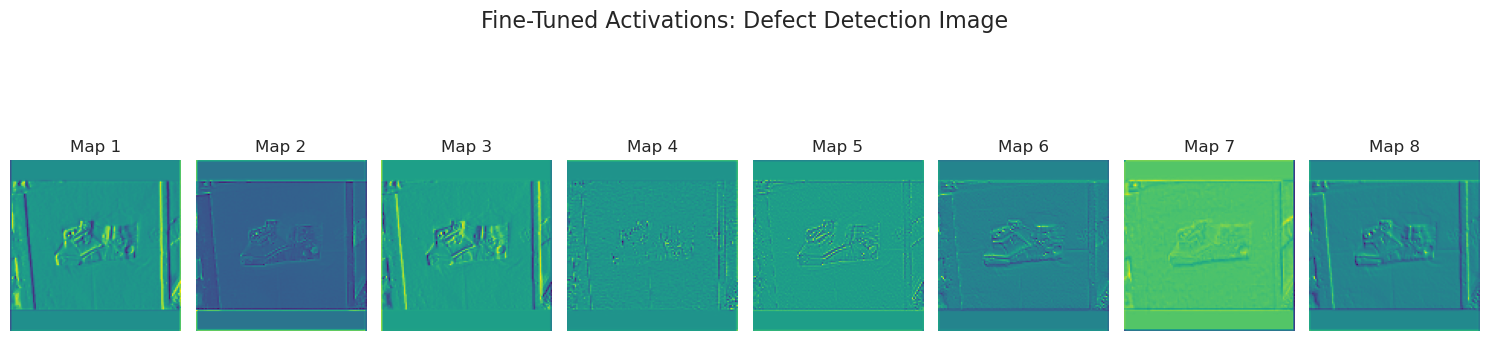

In [22]:
# Step 1: Define the fine-tuned feature extractor using the base model
fine_tuned_feature_extractor = Model(
    inputs=base_model.input,  # Use the base model's input
    outputs=base_model.get_layer('block_1_expand').output  # Extract the output of the desired layer
)

# Step 2: Preprocess the cat image
cat_array = sample_images["cat"]
cat_array = np.expand_dims(cat_array, axis=0)

# Step 3: Select an image from the defect detection dataset
for defect_images, _ in test_dataset.take(1):  # Grab a batch
    defect_image = defect_images[0].numpy()  # Take the first image
    break
defect_array = np.expand_dims(defect_image, axis=0)

# Step 4: Generate activation maps
cat_activations = fine_tuned_feature_extractor.predict(cat_array)
defect_activations = fine_tuned_feature_extractor.predict(defect_array)

# Step 5: Visualize activation maps
def visualize_activation_maps(activations, title, num_maps=8):
    plt.figure(figsize=(15, 8))

    # Display activation maps
    for i in range(num_maps):
        plt.subplot(2, num_maps, i + 1)
        plt.imshow(activations[0, :, :, i], cmap='viridis')
        plt.axis('off')
        plt.title(f"Map {i + 1}")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize activations for the cat image
visualize_activation_maps(cat_activations, "Fine-Tuned Activations: Cat Image")

# Visualize activations for the defect detection image
visualize_activation_maps(defect_activations, "Fine-Tuned Activations: Defect Detection Image")

### Real-World Application: Defect Detection Alert System

In a real-world scenario, a trained model can be deployed as part of an automated quality control pipeline. For example, in a manufacturing environment, the model can evaluate images of parts and provide alerts if defects are detected with high confidence.

Here, we’ll implement a simple **detector function** that:
1. Accepts an input image and a confidence threshold.
2. Predicts whether the image is defective.
3. Returns an "alert" if the defect probability exceeds the threshold.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
ALERT: Defect detected with probability 0.00 (Threshold: 0.25)


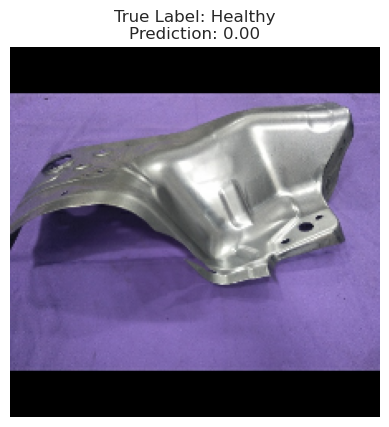

In [23]:
def detect_defect_from_dataset(image_index, dataset, model, threshold=0.25):
    """
    Detects defects in an image from a dataset using the trained model.

    Parameters:
    - image_index (int): Index of the image in the dataset to evaluate.
    - dataset (tf.data.Dataset): The dataset containing the images to evaluate.
    - model (keras.Model): The trained defect detection model.
    - threshold (float): Confidence threshold for triggering an alert.

    Returns:
    - str: Result message with defect probability and alert status.
    """
    # Extract the specified image and its label
    dataset_images, dataset_labels = [], []
    for images, labels in dataset:
        dataset_images.append(images)
        dataset_labels.append(labels)
    dataset_images = np.concatenate(dataset_images, axis=0)
    dataset_labels = np.concatenate(dataset_labels, axis=0)

    img = dataset_images[image_index]
    true_label = dataset_labels[image_index]

    # Preprocess the image (add batch dimension)
    img_array = np.expand_dims(img, axis=0)

    # Step 1: Make a prediction
    prediction = model.predict(img_array)[0][0]  # Get defect probability (scalar)

    # Step 2: Determine result based on the threshold
    if prediction < threshold:
        result = f"ALERT: Defect detected with probability {prediction:.2f} (Threshold: {threshold:.2f})"
    else:
        result = f"OK: No defect detected (Probability: {prediction:.2f}, Threshold: {threshold:.2f})"

    return result, img, true_label, prediction

# Example usage
image_index = 2  # Index of the image to evaluate
threshold = 0.25  # Define a confidence threshold
result, img, true_label, prediction = detect_defect_from_dataset(image_index, test_dataset, model, threshold)

# Display the result
print(result)

# Visualize the image
plt.imshow((img + 1)/2)
plt.axis("off")
plt.title(f"True Label: {'Defective' if true_label else 'Healthy'}\nPrediction: {prediction:.2f}")
plt.show()

### Conclusion

In this lab, we took a deep dive into applying **transfer learning** and **computer vision** techniques to detect defects in automotive parts. By building on the foundational skills introduced earlier in the workshop, we explored advanced workflows for image classification and model adaptation.

Here’s a summary of what we covered:

1. **Dataset Exploration and Preprocessing**:
   - Loaded and visualized the **Fender Apron** dataset to understand the characteristics of defective and healthy parts.
   - Performed preprocessing steps including resizing, normalization, and data augmentation to prepare the dataset for training.

2. **Understanding Pre-trained Models**:
   - Explored how MobileNetV2, pre-trained on ImageNet, extracts features and how these features can be adapted to a new task.
   - Visualized activation maps from early layers to see what the model focuses on before and after fine-tuning.

3. **Model Training and Fine-tuning**:
   - Used the MobileNetV2 architecture as the base model and fine-tuned it for binary classification (defective vs. healthy).
   - Optimized the training process with data augmentation and prefetching for performance improvements.

4. **Evaluation and Insights**:
   - Analyzed the model's performance using metrics like precision, recall, F1-score, and confusion matrices.
   - Inspected misclassified and low-confidence samples to identify patterns and potential edge cases.

5. **Real-world Applications**:
   - Implemented a simple defect detection alert system that could be used in automated quality control pipelines.
   - Demonstrated how a trained model can make predictions on test images and trigger alerts based on confidence thresholds.

---

### Key Takeaways

- **Transfer learning** leverages pre-trained models to save time and computational resources, making it an effective approach for specialized tasks like defect detection.
- Visualizing activation maps and misclassified samples provides deeper insights into model behavior and areas for improvement.
- The combination of data augmentation, efficient preprocessing, and fine-tuning enables the creation of robust and generalizable models.

As we move forward in this workshop, you are encouraged to:
- Experiment with different architectures and data augmentation strategies.
- Investigate ways to improve the model’s performance on edge cases or ambiguous samples.
- Consider deployment strategies for integrating defect detection models into real-world systems.

---

### Bonus Exercise: Trying a Different Pre-trained Model

To deepen your understanding of transfer learning and model fine-tuning, try swapping out MobileNetV2 with a different pre-trained model. This exercise will help you explore the flexibility of pre-trained models and understand the trade-offs between different architectures.

---

#### Step 1: Choose a New Pre-trained Model

Keras provides several pre-trained models in the `tf.keras.applications` module. Some popular choices include:
- **ResNet50**: A deeper architecture designed to learn complex patterns, known for its residual connections.
- **InceptionV3**: A model that uses a creative "Inception" block to capture features at multiple scales.
- **EfficientNetB0**: A highly optimized model that balances accuracy and computational efficiency.

Choose one of these models based on your goals:
- If you want higher accuracy and don’t mind a longer training time, try **ResNet50** or **InceptionV3**.
- If you need efficiency and speed, go with **EfficientNetB0**.

---

#### Step 2: Replace MobileNetV2 with Your Chosen Model

1. Import your chosen model from `tf.keras.applications`.
2. Replace MobileNetV2 in the model setup:
   - Ensure you set `include_top=False` to exclude the original classification head.
   - Specify the input shape `(224, 224, 3)` (or modify it to match your dataset).
3. Freeze the base layers of the new model so you can fine-tune only the top layers.

---

#### Step 3: Adjust Preprocessing

Each pre-trained model has specific preprocessing requirements:
- Use the corresponding `preprocess_input` function from `tf.keras.applications.<model>` to normalize your dataset correctly.
- For example:
  - ResNet50 and InceptionV3 require inputs scaled to [-1, 1].
  - EfficientNetB0 requires inputs scaled to [0, 1].

Update your preprocessing pipeline to match the model’s expectations.

---

#### Step 4: Add New Task-Specific Layers

Attach new layers to adapt the model to your defect detection task:
1. Use a **GlobalAveragePooling2D** layer to reduce spatial dimensions.
2. Add one or more **Dense** layers for additional learning.
3. Use a **Dense(1, activation='sigmoid')** layer as the output for binary classification.

---

#### Step 5: Compile and Train

1. Compile the model using the same loss function (`binary_crossentropy`) and optimizer (`Adam`).
2. Train the model on the same dataset for 15 epochs.
3. Monitor the training and validation accuracy to compare performance with MobileNetV2.

---

#### Step 6: Evaluate and Compare Results

After training, evaluate the model on the testing set using:
1. Accuracy, precision, recall, and F1-score.
2. Confusion matrices and misclassified samples.

Compare the results with those from MobileNetV2:
- Did the new model perform better or worse?
- Was the training time noticeably different?
- Were there any patterns in the errors or low-confidence predictions?

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5377 - loss: 0.7193 - val_accuracy: 0.4510 - val_loss: 0.7224
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5043 - loss: 0.6893

2024-12-02 12:04:05.400663: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5085 - loss: 0.6880 - val_accuracy: 0.5490 - val_loss: 0.7114
Epoch 3/15


2024-12-02 12:04:07.653845: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5228 - loss: 0.7016 - val_accuracy: 0.5882 - val_loss: 0.6871
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6882 - loss: 0.6523 - val_accuracy: 0.5294 - val_loss: 0.6828
Epoch 5/15


2024-12-02 12:04:29.818293: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6156 - loss: 0.6542

2024-12-02 12:04:38.047763: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6078 - loss: 0.6563 - val_accuracy: 0.5490 - val_loss: 0.7006
Epoch 6/15


2024-12-02 12:04:40.318181: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6170 - loss: 0.6516 - val_accuracy: 0.5098 - val_loss: 0.7062
Epoch 7/15


2024-12-02 12:04:50.746402: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4728 - loss: 0.6858 - val_accuracy: 0.5490 - val_loss: 0.7168
Epoch 8/15


2024-12-02 12:05:01.170327: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6053 - loss: 0.6744 - val_accuracy: 0.5686 - val_loss: 0.7029
Epoch 9/15


2024-12-02 12:05:11.585399: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6168 - loss: 0.6424 - val_accuracy: 0.5686 - val_loss: 0.6799
Epoch 10/15


2024-12-02 12:05:22.891773: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6172 - loss: 0.6381 - val_accuracy: 0.5490 - val_loss: 0.6785
Epoch 11/15


2024-12-02 12:05:34.939990: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6081 - loss: 0.6256

2024-12-02 12:05:43.278594: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6081 - loss: 0.6256 - val_accuracy: 0.5490 - val_loss: 0.6762
Epoch 12/15


2024-12-02 12:05:45.587706: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7067 - loss: 0.6105

2024-12-02 12:05:53.941684: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6931 - loss: 0.6155 - val_accuracy: 0.5294 - val_loss: 0.6837
Epoch 13/15


2024-12-02 12:05:56.253815: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6176 - loss: 0.6544

2024-12-02 12:06:04.513870: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6158 - loss: 0.6572 - val_accuracy: 0.6078 - val_loss: 0.6752
Epoch 14/15


2024-12-02 12:06:06.823010: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6077 - loss: 0.6519

2024-12-02 12:06:15.096707: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6040 - loss: 0.6522 - val_accuracy: 0.5294 - val_loss: 0.6857
Epoch 15/15


2024-12-02 12:06:17.384526: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6010 - loss: 0.6416 - val_accuracy: 0.5098 - val_loss: 0.6773


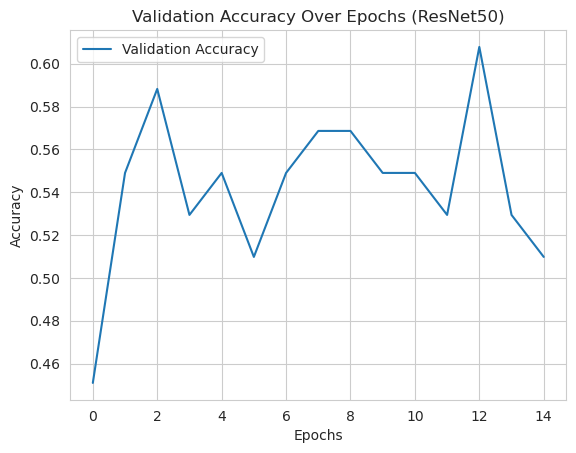

2024-12-02 12:06:27.941790: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 799ms/step - accuracy: 0.5482 - loss: 0.6672
Test Accuracy: 0.51


In [24]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Input
from keras.optimizers import Adam
from keras.applications.resnet50 import preprocess_input
import tensorflow as tf

# Step 1: Load the ResNet50 model without the top layers
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude the classification head
    weights='imagenet'  # Use pre-trained weights from ImageNet
)

# Freeze the base model layers
base_model.trainable = False

# Step 2: Preprocess the dataset for ResNet50
def preprocess(image, label):
    image = preprocess_input(image)  # Rescale to match ResNet50's requirements
    return image, label

train_dataset_resnet = train_dataset.map(preprocess)
test_dataset_resnet = test_dataset.map(preprocess)

# Step 3: Build the new model with task-specific layers
model_resnet = Sequential([
    Input(shape=(224, 224, 3)),       # Input shape
    base_model,                       # Pre-trained ResNet50 base
    GlobalAveragePooling2D(),         # Reduce spatial dimensions
    Dense(128, activation='relu'),    # Fully connected layer
    Dense(1, activation='sigmoid')    # Output layer for binary classification
])

# Step 4: Compile the model
model_resnet.compile(
    optimizer=Adam(learning_rate=0.001),  # Use Adam optimizer
    loss='binary_crossentropy',          # Binary cross-entropy loss
    metrics=['accuracy']                 # Monitor accuracy
)

# Step 5: Train the model
AUTOTUNE = tf.data.AUTOTUNE
train_dataset_resnet = train_dataset_resnet.prefetch(buffer_size=AUTOTUNE)
test_dataset_resnet = test_dataset_resnet.prefetch(buffer_size=AUTOTUNE)

history_resnet = model_resnet.fit(
    train_dataset_resnet,
    epochs=15,
    validation_data=test_dataset_resnet
)

# Step 6: Evaluate the model
import matplotlib.pyplot as plt

# Plot the validation accuracy
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs (ResNet50)')
plt.legend()
plt.show()

# Evaluate on the test set
test_loss, test_accuracy = model_resnet.evaluate(test_dataset_resnet)
print(f"Test Accuracy: {test_accuracy:.2f}")
